In [7]:
from datetime import datetime
from ta import add_all_ta_features
import pandas as pd
import requests
import math
import numpy as np
import time
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
import matplotlib.pyplot as plt
from statistics import mean

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import svm
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

AV_KEY='5AK7ZPDAGCNO39B7'

In [4]:
STOCKS = ['500.PAR'] # ['500.PAR','IBM']
CRYPTOS = ['BTC','ETH']
LABEL_SYMBOL = '500.PAR'
DIFFS = {1:3, 5:3, 20:3}
LABEL = 'close'
LOOK_AHEAD = ['open']
NAN_LIMIT = 100 #remove 
NO_SAMPLES = 500
TRAINING_RATIO = 0.5

In [2]:
TECHNICAL_COLS = ['volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']

In [30]:
class Binary_Predictor:
    def __init__(self, threshold, leverage, exit_method, models, pred_method = 'ave', capture_thresh = 0.01):
        self.exit_method = exit_method
        self.threshold = threshold
        self.leverage = leverage # percent of the base pal is multiplied by this, leverage = 1 / margin_req
        self.models = models
        self.pred_method = pred_method
        self.capture_thresh = capture_thresh
        
    def get_agg_prediction(self, index, prediction_dict):
        preds = []
        for model in self.models:
            mod_preds = prediction_dict[model]
            preds.append(prediction_dict[model].iloc[index]['prediction'])
        if self.pred_method == 'ave':
            return mean(preds)
                       
    def bet_dir(self, prediction):
        if prediction >= 1:
            return 1
        return -1
    
    def exit_at(self, prediction, open, close, high, low):
        if self.exit_method == 'at_close':
            return close
        elif self.exit_method == 'capture_gains':
            if self.bet_dir(prediction) < 0 and low <= open - open * self.capture_thresh:
                return open - open * self.capture_thresh
            elif self.bet_dir(prediction) > 0 and high >= open + open * self.capture_thresh:
                return open + open * self.capture_thresh
            else:
                return close
            
    def percent_pal(self, prediction, open, close, high, low):
        bet_dir = self.bet_dir(prediction)
        exit_price = self.exit_at(prediction, open, close, high, low)
        return (exit_price - open) / open * bet_dir * self.leverage

def GetStockPriceDF(symbol): 
    cols = ['open', 'high', 'low', 'close', 'volume']
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+symbol+'&outputsize=full&apikey='+AV_KEY
    print(url)
    try:
        r = requests.get(url)
        data = r.json()
        dic = data['Time Series (Daily)']
        df = pd.DataFrame.from_dict(dic, orient='index')
        df = df[['1. open', '2. high', '3. low', '4. close', '6. volume']]
        df = df.rename(columns={'1. open': 'open', '2. high': 'high', '3. low': 'low','4. close':'close', '6. volume':'volume'})
        df.index.name = 'date'
        df = df.sort_index(ascending = True)
        df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
        return df
    except Exception as e: print(e)
    return None

def GetCryptoPriceDF(symbol): 
    cols = ['open', 'high', 'low', 'close', 'volume']
    url = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol='+symbol+'&market=CNY&apikey='+AV_KEY
    print(url)
    r = requests.get(url)
    data = r.json()
    dic = data['Time Series (Digital Currency Daily)']
    df = pd.DataFrame.from_dict(dic, orient='index')
    df = df[['1a. open (CNY)', '2a. high (CNY)', '3a. low (CNY)', '4a. close (CNY)', '5. volume']]
    df = df.rename(columns={'1a. open (CNY)': 'open', '2a. high (CNY)': 'high', '3a. low (CNY)': 'low', '4a. close (CNY)': 'close', '5. volume':'volume'})
    df.index.name = 'date'
    df = df.sort_index(ascending = True)
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    return df

def CalculateTechnicals(df, technical_cols):
    cols = ['open', 'high', 'low', 'close', 'volume']
    technicals = add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume")
    technicals = technicals[technical_cols]
    return technicals

def SampleDataframe(df, date, no_samples):
    ind = df.index.get_loc(date)
    if ind-no_samples > 0:
        df = df.iloc[ind+1-no_samples:ind+1,:]
        return df
    return None

def DiffShift(df, columns, diffs):
    final_dfs = []
    for diff in diffs.keys():
        diff_df = pd.DataFrame()   
        for col in columns:
            if diff == 0:
                diff_df[col] = df[col]
            else:
                diff_df[col+'_D'+str(diff)] = df[col].rolling(window=diff+1).apply(lambda x: x.iloc[diff] - x.iloc[0])
        sampled_dfs = []
        for shift in diffs[diff]:
            sampled_df = diff_df.shift(periods=shift)
            sampled_df = sampled_df.add_suffix('_S'+str(shift))
            sampled_dfs.append(sampled_df)
        final_df = pd.concat(sampled_dfs, axis=1, join="inner")
        final_dfs.append(final_df)   
    pivot_df = pd.concat(final_dfs, axis=1, join="inner")
    return pivot_df

def DownloadStocks(stocks):
    stock_dict = {}
    for symbol in stocks:
        time.sleep(5)
        df = GetStockPriceDF(symbol)
        if df is not None:
            stock_dict[symbol] = df
        else:
            print("can't download " + symbol)
    return stock_dict

def CreateDataset(stock_dict, pivot_cols, pivots, peak_cols, technical_cols, label_symbol, label_col):
    full_res, label_df, base_prices = [], None, None
    for symbol in stock_dict: 
        print(symbol)
        sym_dfs = []
        df = stock_dict[symbol]

        #print(df)
        sym_dfs.append(DiffShift(df, pivot_cols, pivots)) # pivot
        sym_dfs.append(DiffShift(df, peak_cols, {1:[0]})) # peak ahead
        technicals = CalculateTechnicals(df, technical_cols) # calculate technicals
        #print(technicals)
        sym_dfs.append(DiffShift(technicals, technical_cols, {0:[1]})) #shifted technicals
        sym_df = pd.concat(sym_dfs, axis=1, join="inner").add_prefix(symbol + '_') #combined symbol data
        full_res.append(sym_df)
        
        if symbol == label_symbol:
            label_df = df
            label_df['label'] = np.where(label_df['close']>label_df['open'], 1, 0)
            label_df = label_df['label']
            base_prices = df[['open','high','low','close']]
            
    full_res.append(label_df)
    res_df = pd.concat(full_res, axis=1, join='inner')
    base_prices = base_prices[base_prices.index.isin(res_df.index)]
    return res_df, base_prices

# sklearn models
def Reverse_Scale(scaler, y, data_width):
    holder = np.zeros((y.shape[0], data_width))
    holder[:,-1] = y
    holder = scaler.inverse_transform(holder)
    return holder[:,-1]

def TrainForDate(sampled_df, test_size, model, param_grid, pca_comps, no_its):
    data = sampled_df.to_numpy()
    features, label = data[:,:-1], data[:,-1]
    scaler = StandardScaler()
    scl_data = scaler.fit_transform(features)
    x, y = scl_data, label

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

    #fit pca on train, transform test
    pca = PCA(n_components=pca_comps)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)
    
    print('pca variance: ' + str(sum(pca.explained_variance_ratio_)))

    clf = GridSearchCV(model, param_grid, refit=True, scoring='neg_root_mean_squared_error')
    best_model = clf.fit(x_train, y_train) # model.fit(x_train,y_train)
    y_train_pred = best_model.predict(x_train)
    y_test_pred = best_model.predict(x_test)

    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
              
    #y_train_pred = best_model.predict(x_train)
    #y_test_pred = best_model.predict(x_test)
    #y_test_pred_oscale = Reverse_Scale(scaler, y_test_pred, data.shape[1])
    #y_test_acts_oscale = Reverse_Scale(scaler, y_test, data.shape[1])
    #plt.plot(y_test_pred_oscale, label = "predictions")
    #plt.plot(y_test_acts_oscale, label = "actual")
    #plt.show()
    
    #y_train_pred = best_model.predict(x_train)
    #y_test_pred = best_model.predict(x_test)
    #y_test_pred_oscale = Reverse_Scale(scaler, y_test_pred, data.shape[1])
    #y_test_acts_oscale = Reverse_Scale(scaler, y_test, data.shape[1])
    #best_mse_oscale = mean_squared_error(y_test_acts_oscale, y_test_pred_oscale, squared=False)
    
    print('Params: ' + str(best_model.best_params_))
    PlotPredVsAct(y_test_pred, y_test, 'acc: ' + str(accuracy_test) + ', f1: ' + str(f1_test))
    
    return scaler, pca, best_model, f1_test
    
def PlotPredVsAct(pred, acts, title):
    plt.figure(figsize=(7, 2))
    plt.plot(pred, label = "predictions")
    plt.plot(acts, label = "actual")
    plt.legend(loc="upper left")
    
    plt.title(title)
    plt.show()
    
def PredictForDate(df, prev_price, date, scaler, pca, model):
    sampled_df = SampleDataframe(df, date, 1)
    data = sampled_df.to_numpy()
    x, y = data[:,:-1], data[:,-1]
    x = scaler.transform(x)
    x = pca.transform(x)
    y_pred = model.predict(x)
    return y_pred

def GenerateModelResults(df, base_prices, model_param_sets, pca_comps, no_its, no_samples, test_size, regression_range):
    model_sets_results = {}
    for key in model_param_sets:
        model_param_set = model_param_sets[key]
        res_dict = {'date':[], 'open':[], 'close':[], 'prediction':[], 'test_mse':[]}
        for i in regression_range:
            date = df.index[i]
            prev_date = df.index[i-1]
            open = base_prices.iloc[i]['open']
            close = base_prices.iloc[i]['close']

            sampled_df = SampleDataframe(df, prev_date, no_samples)
            scaler, pca, model, test_MSE = TrainForDate(sampled_df, test_size, model_param_set[0], model_param_set[1], pca_comps, no_its)
            prev_price = base_prices.iloc[i-1,-1]
            pred = PredictForDate(df, prev_price, date, scaler, pca, model)

            res_dict['date'].append(date)
            res_dict['open'].append(open)
            res_dict['close'].append(close)
            res_dict['prediction'].append(pred[0])
            res_dict['test_mse'].append(test_MSE)

        model_sets_results[key] = pd.DataFrame(res_dict)
    return model_sets_results

def GeneratePredictorResults(df, base_prices,predictors,model_sets_results, rolls=[5,10,20]):
    predictors_results = {}
    for pred_key in predictors:
        res_dict = {'date':[],'open':[], 'close':[], 'high':[], 'low':[], 'agg_prediction':[], 'bet_dir':[], 'exit_price':[], 'act_perc_pal':[]}
        x = 0
        for i in regression_range:
            date = df.index[i]
            open = base_prices.iloc[i]['open']
            close = base_prices.iloc[i]['close']
            high = base_prices.iloc[i]['high']
            low = base_prices.iloc[i]['low']

            predictor = predictors[pred_key]
            res_dict['date'].append(date)
            res_dict['open'].append(open)
            res_dict['close'].append(close)
            res_dict['high'].append(high)
            res_dict['low'].append(low)
            agg_pred = predictor.get_agg_prediction(x,model_sets_results)
            res_dict['agg_prediction'].append(agg_pred)
            res_dict['bet_dir'].append(predictor.bet_dir(agg_pred))
            res_dict['exit_price'].append(predictor.exit_at(agg_pred, open, close, high, low))
            res_dict['act_perc_pal'].append(predictor.percent_pal(agg_pred, open, close, high, low))
            x+=1

        metrics = pd.DataFrame(res_dict)
        for roll in rolls:
            metrics[str(roll) + 'D_mean'] = metrics['act_perc_pal'].rolling(roll).mean()
            metrics[str(roll) + 'D_cumprod'] = (1 + metrics['act_perc_pal']).rolling(roll).apply(np.prod, raw=True) - 1
        predictors_results[pred_key] = metrics
    return predictors_results

def PlotPredictorResults(PredictorName, PredictorResults):
    fig, axs = plt.subplots(2,2, figsize=(12,6))
    axs[0, 0].set_title('rolling means')
    axs[0, 1].set_title('cumulative prods')
    
    for roll in [5,10,20]:
        mean_data = PredictorResults[str(roll) + 'D_mean'].dropna()
        sns.lineplot(data = PredictorResults, x = 'date', y = str(roll) + 'D_mean' , ax=axs[1,0])
        sns.kdeplot(mean_data,bw=0.25,ax=axs[0,0])

        cump_data = PredictorResults[str(roll) + 'D_cumprod'].dropna()
        sns.lineplot(data = PredictorResults, x = 'date', y = str(roll) + 'D_cumprod' , ax=axs[1,1])
        sns.kdeplot(cump_data,bw=0.25,ax=axs[0,1])
        
        if roll == 20:
            print(PredictorName + ', average 20D mean: ' + str(mean_data.mean()) + ', average 20 cumprod: ' + str(cump_data.mean()))
    plt.show()

In [4]:
stocks = ['500.PAR','NDAQ','DAX','AAPL','MSFT','AMZN','FB','GOOGL','GOOG','TSLA']
stock_dict = DownloadStocks(stocks)

https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=500.PAR&outputsize=full&apikey=5AK7ZPDAGCNO39B7
https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=NDAQ&outputsize=full&apikey=5AK7ZPDAGCNO39B7
https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=DAX&outputsize=full&apikey=5AK7ZPDAGCNO39B7
https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=AAPL&outputsize=full&apikey=5AK7ZPDAGCNO39B7
https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=MSFT&outputsize=full&apikey=5AK7ZPDAGCNO39B7
https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=AMZN&outputsize=full&apikey=5AK7ZPDAGCNO39B7
https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=FB&outputsize=full&apikey=5AK7ZPDAGCNO39B7
https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=GOOGL&outputsize=full&apikey=5AK7ZPDAGCNO39B7
https://www.alphavantag

In [5]:
pivot_cols = ['open'] # ['open','high','low','close','volume']
pivots = {1:[1,2,3,4,5,6,7,8,9,10],10:[10,20,30]}
peak_cols = ['open']
technical_cols = TECHNICAL_COLS #['volume_adi']
label_symbol = '500.PAR'
label_col = 'close'

df, base_prices = CreateDataset(stock_dict, pivot_cols, pivots, peak_cols, technical_cols, label_symbol, label_col) 
print(df.tail())
print(base_prices.tail())

500.PAR
NDAQ
DAX
AAPL
MSFT
AMZN
FB
GOOGL
            500.PAR_open_D1_S1  500.PAR_open_D1_S2  500.PAR_open_D1_S3  \
date                                                                     
2021-12-06              0.8385             -0.9481             -0.1380   
2021-12-07             -0.1716              0.8385             -0.9481   
2021-12-08              1.0051             -0.1716              0.8385   
2021-12-09              1.1616              1.0051             -0.1716   
2021-12-10             -0.2813              1.1616              1.0051   

            500.PAR_open_D1_S4  500.PAR_open_D1_S5  500.PAR_open_D1_S6  \
date                                                                     
2021-12-06             -0.8832              0.1694             -1.8116   
2021-12-07             -0.1380             -0.8832              0.1694   
2021-12-08             -0.9481             -0.1380             -0.8832   
2021-12-09              0.8385             -0.9481             -0.1380

In [6]:
sampled_df = SampleDataframe(df, '2021-11-24', 300)
for col in sampled_df.columns:
    if sampled_df[col].isnull().values.any():
        print(col)
        print(sampled_df[col].isnull().values)

pca variance: 0.9827781295123453
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


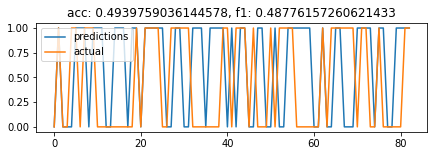

pca variance: 0.9828946641276789
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


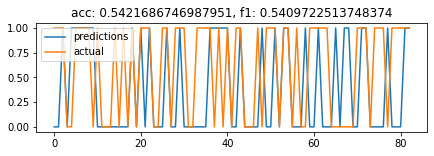

pca variance: 0.9829701627409888
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


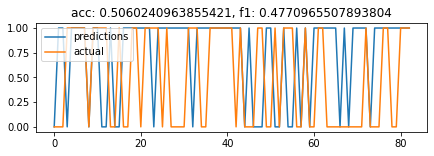

pca variance: 0.9829176994834486
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


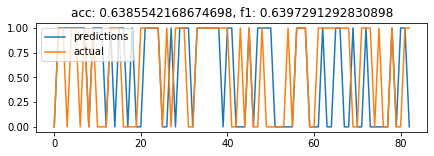

pca variance: 0.9831794903066513
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


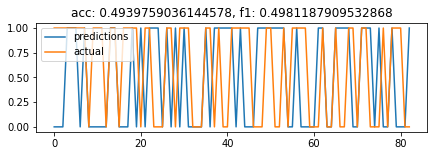

pca variance: 0.9828602592528461
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


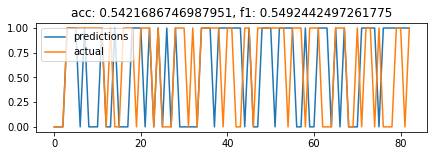

pca variance: 0.9828135486703184
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


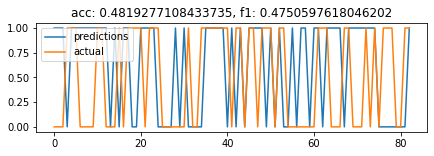

pca variance: 0.9831242339962672
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


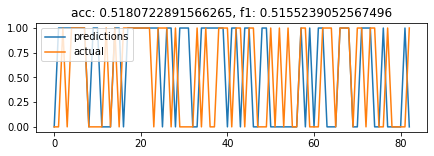

pca variance: 0.9830098368219286
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


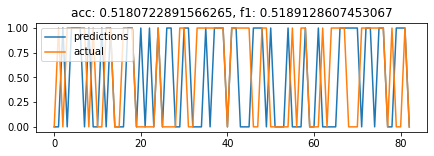

pca variance: 0.9829347290173182
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


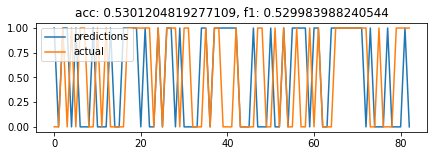

pca variance: 0.9827986089796761
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


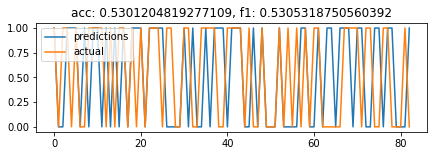

pca variance: 0.9829784408204956
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


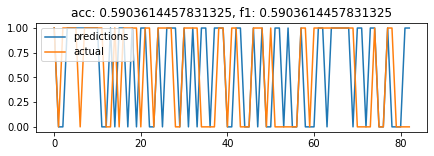

pca variance: 0.9827736543914591
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


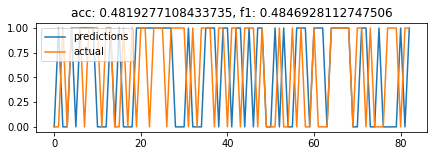

pca variance: 0.9827628454508374
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


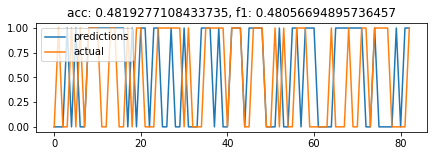

pca variance: 0.9820936774068428
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


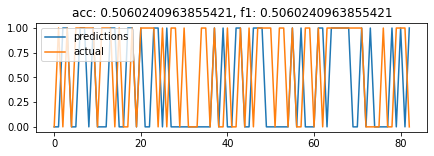

pca variance: 0.9819616697501897
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


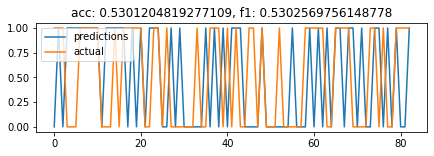

pca variance: 0.9821291306390102
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


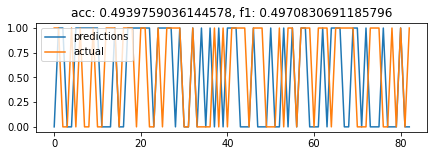

pca variance: 0.9830525720782272
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


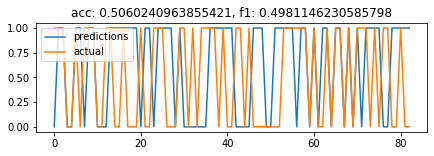

pca variance: 0.9829293567707159
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


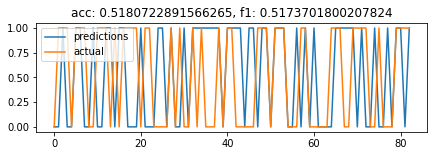

pca variance: 0.9830729834015673
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 300, 'solver': 'adam'}


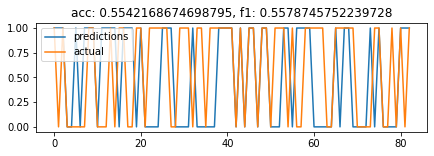

pca variance: 0.9821846459241064
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


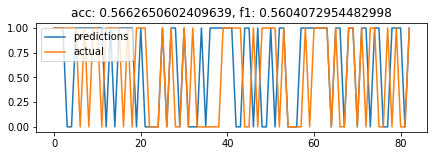

pca variance: 0.9828904008744531
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 16), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


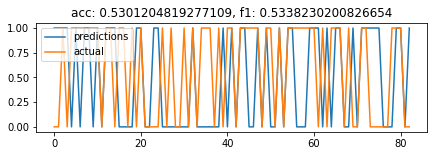

pca variance: 0.9831380727823741
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


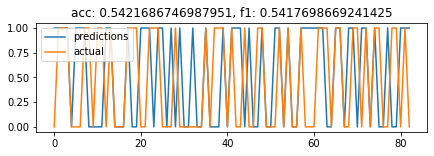

pca variance: 0.9828167101797872
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


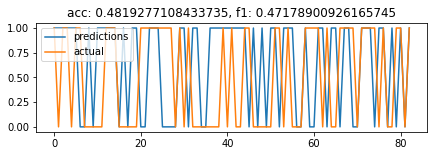

pca variance: 0.9829570152720941
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


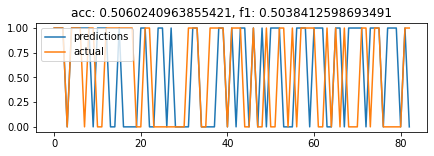

pca variance: 0.9827218866234609
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


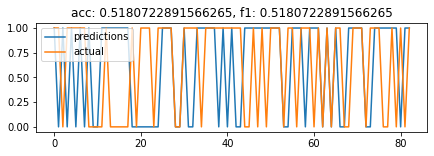

pca variance: 0.9826858374753527
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


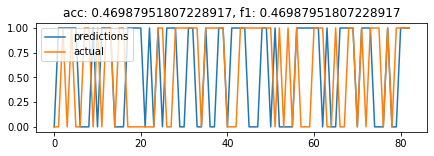

pca variance: 0.9830837775391733
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


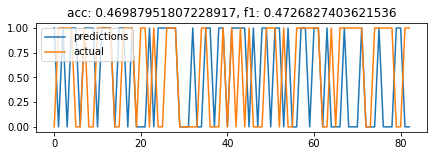

pca variance: 0.9826981643673972
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


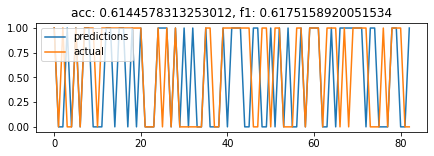

pca variance: 0.982738660698164
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


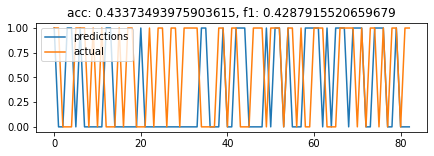

pca variance: 0.9831720645468538
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


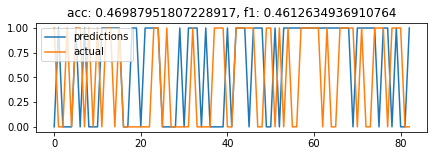

pca variance: 0.9830802594888169
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


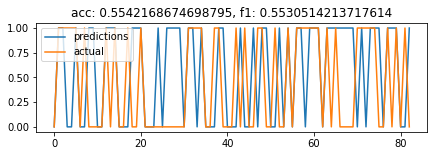

pca variance: 0.9827001759400324
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


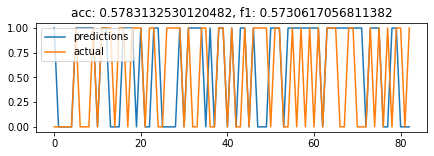

pca variance: 0.9830875161635597
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


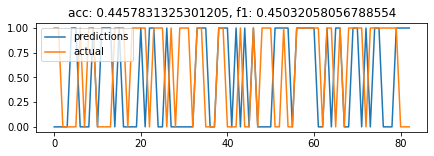

pca variance: 0.9830078109224343
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


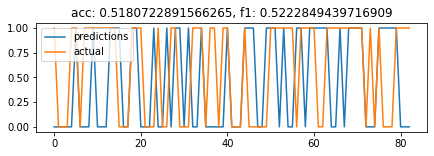

pca variance: 0.9826724374723317
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


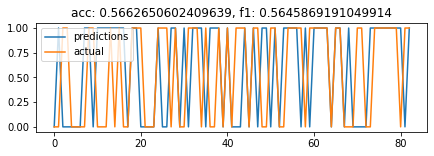

pca variance: 0.9820872357294421
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


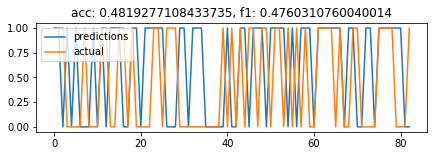

pca variance: 0.9821373375241507
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


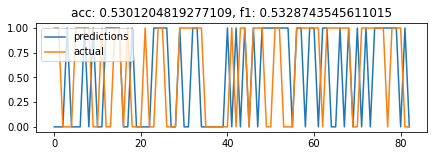

pca variance: 0.982267244560104
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


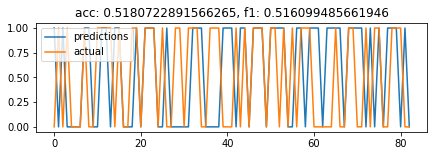

pca variance: 0.9825245594026292
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 300, 'solver': 'adam'}


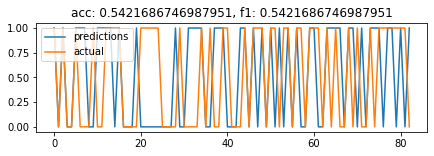

pca variance: 0.9825685568627477
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 300, 'solver': 'adam'}


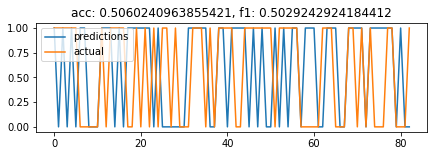

pca variance: 0.9826784044364635
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


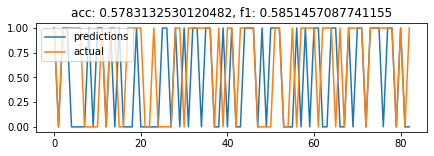

pca variance: 0.9824802064806016
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


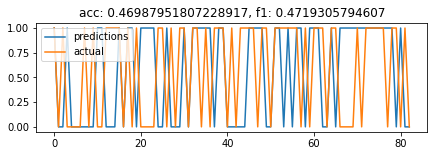

pca variance: 0.9820379830835542
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


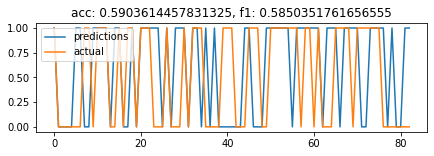

pca variance: 0.9825099754196834
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


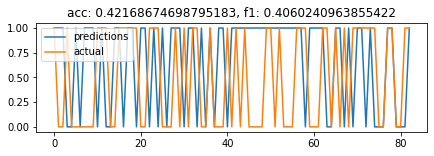

pca variance: 0.9825457064466383
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


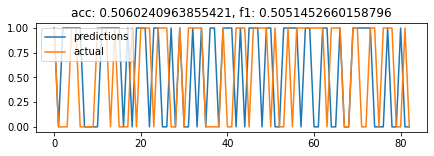

pca variance: 0.9822893962458046
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 16), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


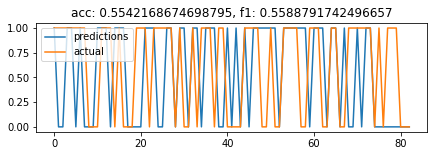

pca variance: 0.9825160955318231
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


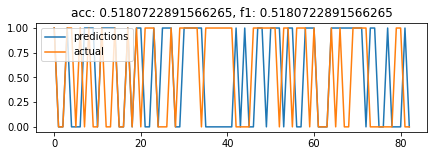

pca variance: 0.982023453193845
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


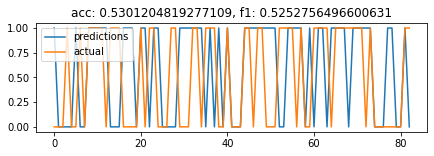

pca variance: 0.9823862750448404
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


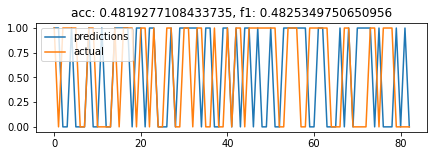

In [25]:
#model training parameters
regression_range = range(len(df.index)-50,len(df.index))

pca_comps = 100
no_samples = 250
test_size = 0.33
no_its = 1

model_param_sets = {'M1': (MLPClassifier(random_state=42), {'hidden_layer_sizes':[(64,16),(56,28),(28,14),(64,32,16)], 'max_iter':[100,200,300], 'activation':['relu'], 'solver':['adam'], 'learning_rate_init':[0.001,0.01]})}#,
                    #'M2': (SVC(gamma=2),{'C':[0.025,0.25,1]}),
                    #'M3': (DecisionTreeClassifier(),{'max_depth':[5,10]}),
                    #'M4': (RandomForestClassifier(),{'max_depth':[5,10], 'n_estimators':[5,10],'max_features':[1]})}

model_sets_results = GenerateModelResults(df, base_prices, model_param_sets, pca_comps, no_its, no_samples, test_size, regression_range)

In [26]:
model_sets_results['M1']

,date,open,close,prediction,test_mse
0,2021-10-01,69.3260,70.1157,0.0,0.487762
1,2021-10-04,70.1465,69.2680,1.0,0.540972
2,2021-10-05,69.7227,70.5850,1.0,0.477097
3,2021-10-06,70.0788,70.1720,0.0,0.639729
4,2021-10-07,71.2665,71.8690,1.0,0.498119
5,2021-10-08,71.7390,71.5075,1.0,0.549244
6,2021-10-11,71.0699,71.6314,1.0,0.475060
7,2021-10-12,70.4148,71.0449,1.0,0.515524
8,2021-10-13,70.6458,70.5409,1.0,0.518913
9,2021-10-14,71.0780,71.8020,1.0,0.529984


sell at close, average 20D mean: 0.005729871567298604, average 20 cumprod: 0.12313371455226108


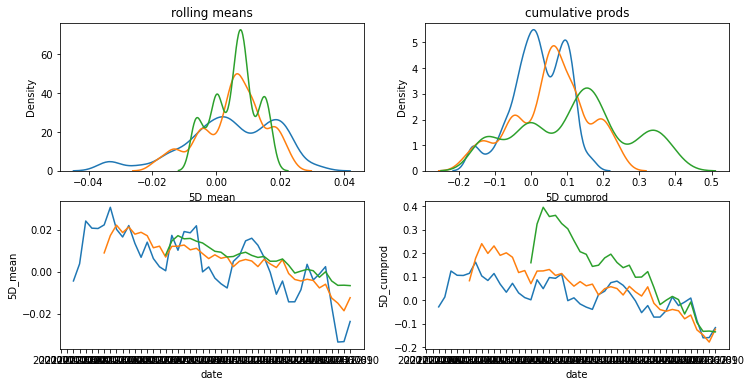

capture gains, average 20D mean: 0.004930580781074134, average 20 cumprod: 0.10524414398785248


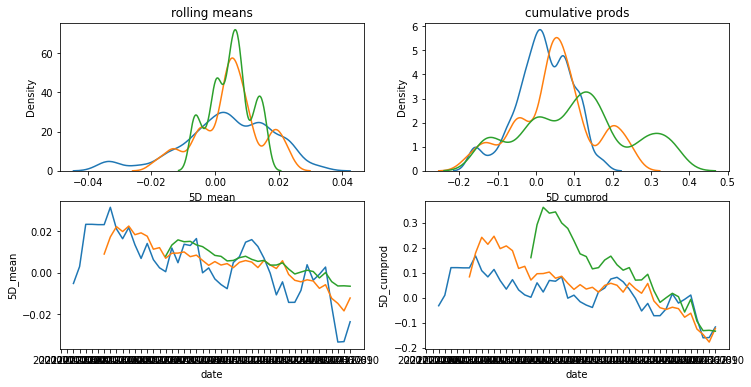

In [31]:
predictors = {'sell at close': Binary_Predictor(threshold=0.005, leverage=5, exit_method='at_close', models=['M1'], pred_method='ave'),
             'capture gains': Binary_Predictor(threshold=0.005, leverage=5, exit_method='capture_gains', models=['M1'], pred_method='ave', capture_thresh = 0.01)}

predictor_results = GeneratePredictorResults(df, base_prices, predictors, model_sets_results)
x = [PlotPredictorResults(x, predictor_results[x]) for x in predictor_results]

In [32]:
predictor_results['sell at close']

,date,open,close,high,low,agg_prediction,bet_dir,exit_price,act_perc_pal,5D_mean,5D_cumprod,10D_mean,10D_cumprod,20D_mean,20D_cumprod
0,2021-10-01,69.3260,70.1157,70.1157,69.2354,0.0,-1,70.1157,-0.056956,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-04,70.1465,69.2680,70.3220,69.2680,1.0,1,69.2680,-0.062619,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-10-05,69.7227,70.5850,70.6183,69.7000,1.0,1,70.5850,0.061838,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-10-06,70.0788,70.1720,70.4488,69.7600,0.0,-1,70.1720,-0.006650,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-10-07,71.2665,71.8690,72.0000,71.2584,1.0,1,71.8690,0.042271,-0.004423,-0.028172,NaN,NaN,NaN,NaN
5,2021-10-08,71.7390,71.5075,71.7800,71.3970,1.0,1,71.5075,-0.016135,0.003741,0.013895,NaN,NaN,NaN,NaN
6,2021-10-11,71.0699,71.6314,71.6715,71.0000,1.0,1,71.6314,0.039503,0.024166,0.124353,NaN,NaN,NaN,NaN
7,2021-10-12,70.4148,71.0449,71.1998,70.4000,1.0,1,71.0449,0.044742,0.020746,0.106251,NaN,NaN,NaN,NaN
8,2021-10-13,70.6458,70.5409,70.9581,70.4289,1.0,1,70.5409,-0.007424,0.020591,0.105388,NaN,NaN,NaN,NaN
9,2021-10-14,71.0780,71.8020,71.8265,71.0000,1.0,1,71.8020,0.050930,0.022323,0.114571,0.008950,0.083172,NaN,NaN


In [163]:
predictor_results['P2']

,date,open,close,high,low,agg_prediction,expected_perc_pal,bet_made,bet_dir,exit_price,act_perc_pal,5D_mean,5D_cumprod,10D_mean,10D_cumprod,20D_mean,20D_cumprod
0,2021-10-08,48.420,48.455,48.515,48.390,47.903753,0.031986,True,-1,48.455000,-0.002169,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-11,48.475,48.595,48.695,48.465,48.499753,0.001532,False,0,48.499753,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-10-12,48.595,48.355,48.600,48.355,48.945753,0.021654,True,1,48.355000,-0.014816,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-10-13,47.915,48.035,48.180,47.910,47.865065,0.003126,False,0,48.035000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-10-14,48.280,48.365,48.500,48.260,48.341763,0.003838,False,0,48.341763,0.000000,-0.003397,-0.016953,NaN,NaN,NaN,NaN
5,2021-10-15,48.065,48.075,48.180,48.065,48.607014,0.033830,True,1,48.075000,0.000624,-0.002838,-0.014201,NaN,NaN,NaN,NaN
6,2021-10-18,48.380,48.570,48.620,48.380,48.533901,0.009543,False,0,48.533901,0.000000,-0.002838,-0.014201,NaN,NaN,NaN,NaN
7,2021-10-19,48.735,48.835,48.905,48.700,49.252063,0.031829,True,1,48.835000,0.006156,0.001356,0.006784,NaN,NaN,NaN,NaN
8,2021-10-20,49.115,48.850,49.330,48.790,49.283309,0.010280,True,1,49.283309,0.010280,0.003412,0.017134,NaN,NaN,NaN,NaN
9,2021-10-21,48.920,49.150,49.150,48.920,49.093601,0.010646,True,1,49.093601,0.010646,0.005541,0.027962,0.001072,0.010536,NaN,NaN
